# Example of how to read and parse the data file save from the rogue software

In [1]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from scipy.optimize import curve_fit
top_level=f'{os.getcwd()}/..'

# Waveforms variables to be filled
adcLive = { i : []  for i in range(4) }
ampLive = { i : []  for i in range(4) }  
adcFault = { i : []  for i in range(4) }
ampFault = { i : []  for i in range(4) }  

# Open the .dat file
with fileio.FileReader(files=f'{top_level}/data/ExampleData_3054MSPS_2GHzSignal.dat') as fd:
    
    # Loop through the file data
    for header,data in fd.records():

        # Convert the numpy array to 16-bit values
        rawData = data[16:].view(np.int16)
        
        # Check for error in frame
        if (header.error>0):
            # Look at record header data
            print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
            print(f"Record size    = {header.size}")
            print(f"Record channel = {header.channel}")
            print(f"Record flags   = {header.flags:#x}")
            print(f"Record error   = {header.error:#x}")

        # Check if ADC Live waveform
        elif header.channel < 4:
            adcLive[header.channel-0].append(rawData)

        # Check if AMP Live waveform
        elif header.channel < 8:
            ampLive[header.channel-4].append(rawData)        

        # Check if ADC Live waveform
        elif header.channel < 12:
            adcFault[header.channel-8].append(rawData)

        # Check if AMP Live waveform
        elif header.channel < 16:
            ampFault[header.channel-12].append(rawData)  
        
        # Else undefined stream index
        else:
            print('UNDEFINED DATA STREAM!!!')

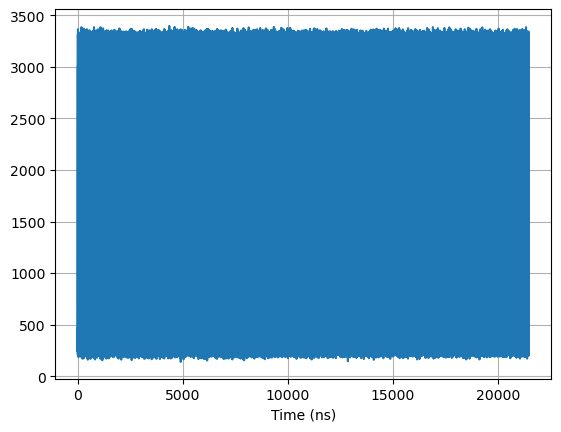

In [2]:
size = len(ampFault[2][1])
timeBin = 1.0/(0.509*6.0) # Unit of ns for 3.054 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.plot(timeSteps,ampFault[2][1])
plt.xlabel("Time (ns)")
plt.grid()

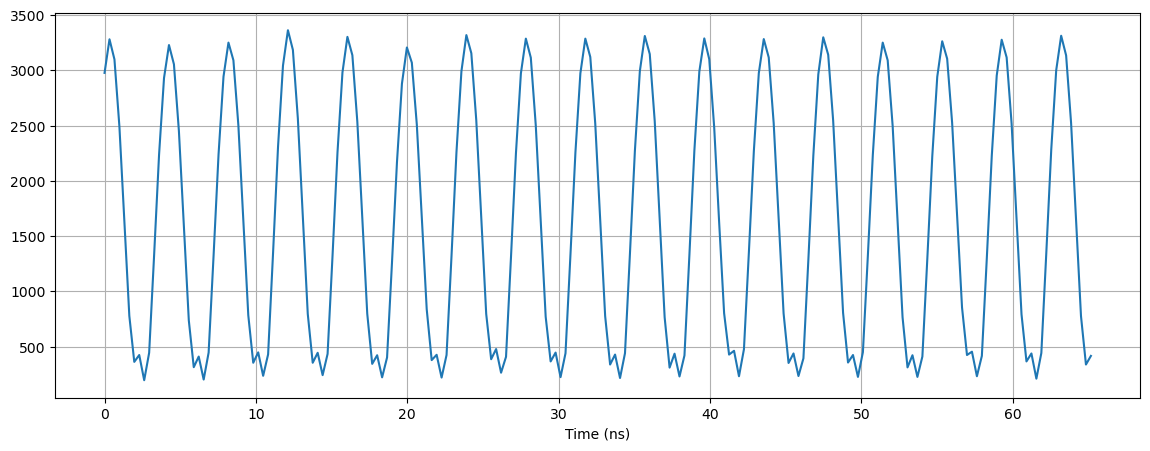

In [22]:
plt.figure(figsize=(14,5))
plt.plot(timeSteps[0:200],ampFault[3][7][0:200])
plt.xlabel("Time (ns)")
plt.grid()

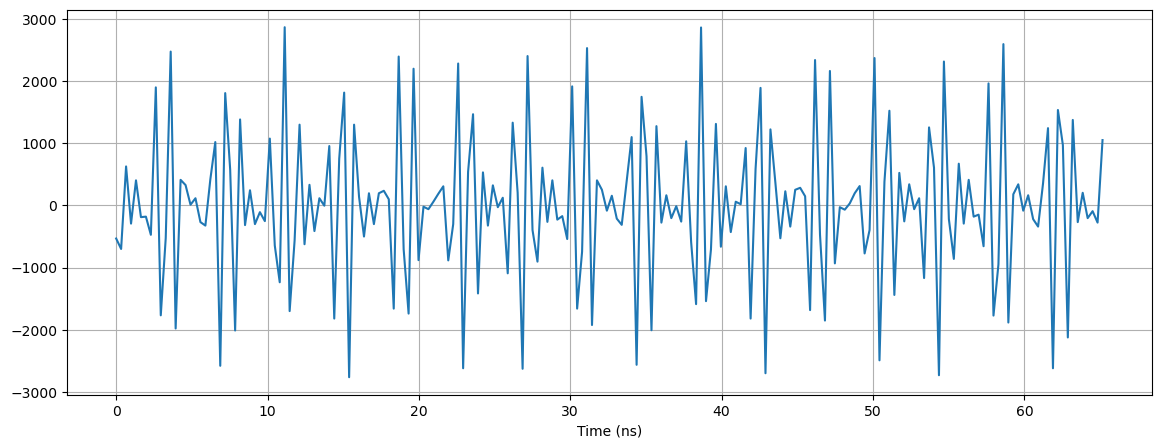

In [107]:
plt.figure(figsize=(14,5))
plt.plot(timeSteps[0:200],adcLive[3][1][0:200])
plt.xlabel("Time (ns)")
plt.grid()

# make histogram of peak value (using peaksearch method)

In [236]:
#search peak and average
def peak_search(waveform_data,threshold):
    mountain_maxima = []
    data_length = len(waveform_data)
    noise_threshold = threshold
    for i in range(3, data_length - 4):
        if waveform_data[i] > waveform_data[i - 1] and waveform_data[i] > waveform_data[i + 1]:
            candidate_peak = waveform_data[i]
            if candidate_peak > noise_threshold:
                mountain_maxima.append(candidate_peak)
    return mountain_maxima

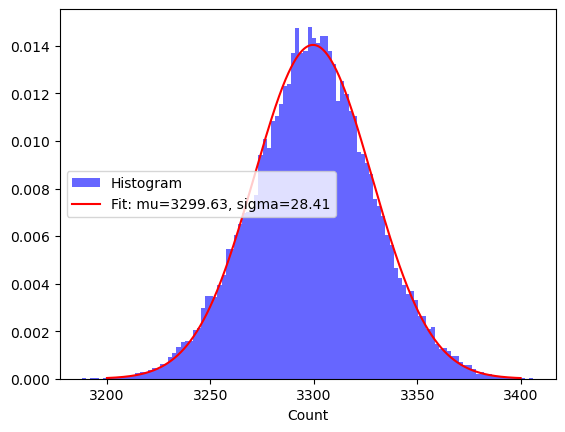

In [120]:
data=peak_search(np.concatenate(ampFault[2]),3000)
bin=110

hist, bins = np.histogram(data, bins=bin, density=True)
width = bins[1] - bins[0]
center = (bins[:-1] + bins[1:]) / 2

plt.hist(data, bins=bin, density=True, alpha=0.6, color='b', label='Histogram')

def fit_function(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

initial_params = [3300, 100]

params, params_covariance = curve_fit(fit_function, center, hist, p0=initial_params)

mu, sigma = params

x = np.linspace(3200, 3400, 10000)
fitted_curve = fit_function(x, mu, sigma)
plt.plot(x, fitted_curve, 'r-', label='Fit: mu={:.2f}, sigma={:.2f}'.format(mu, sigma))

plt.xlabel('Count')
plt.legend()
plt.show()

